In [33]:
"""色々準備"""
import qiskit
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram

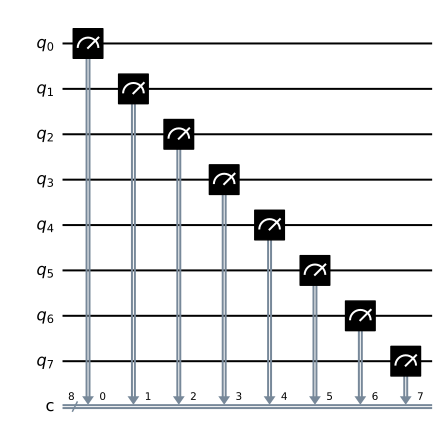

In [34]:
"""はじめての量子回路
"""
n = 8   # 量子ビット数：8
nq = n  # 回路内の量子ビットの数
nb = n  # 出力ビット数
qc_output = QuantumCircuit(nq, nb)

# 回路qcを測定する。量子ビットjの状態を出力ビットjに書き込む
for j in range(n):
    qc_output.measure(j,j)

# 作成した回路の中身を見てみる
qc_output.draw()

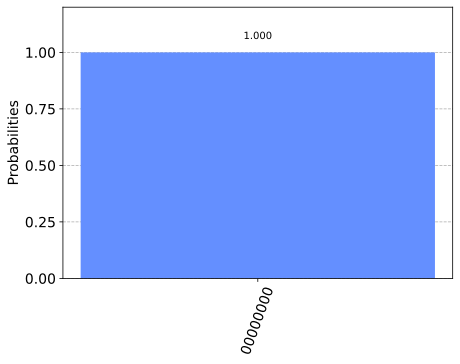

In [35]:
""" 量子ビットは、最初は0に初期化されている。
上記の回路は量子ビットになんの操作もしていないので、測定したときに得られる各出力ビットの結果は必ず0である。
回路を何度も実行し、結果をヒストグラムにプロットすることで確認できる。
出力ビットの0~7番目のビットは、毎回00000000になる。

何回も実行して結果をヒストグラムに表示する理由は、量子コンピュータの計算結果は確率的に決まるからである。
今回の場合は、何も量子的な計算を行っていないため、00000000の結果を確実に出力する。
"""
counts = execute(qc_output, Aer.get_backend("qasm_simulator")).result().get_counts()
plot_histogram(counts)

# 今回の結果は、量子シミュレータから得ていることに注意
実際の量子コンピュータを使っていない（ローカルのPCなのでそれはそう）。
シミュレーションは少数の量子ビットに対してのみ可能だが、それでも最初の量子回路を設計する際には非常に便利なツールである。

実際の量子デバイスで実行するには、Aer.get_background()に、使用したいデバイスのバックエンドオブジェクトを指定すればOK

# 4.加算回路を作成する
## 4.1 入力をエンコードする

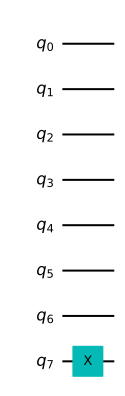

In [36]:
# エンコードのジョブ専用の新しい回路 qc_encode を作成する

qc_encode = QuantumCircuit(n)
qc_encode.x(7)  # X演算（NOT）を、7番目の量子ビットに適用

qc_encode.draw()

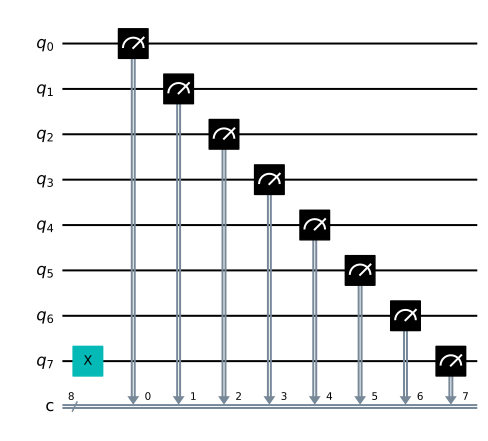

In [37]:
# 結果の抽出は、以前のqc_output回路を使用する。

qc = qc_encode + qc_output  # qc_encodeの後ろに、qc_outputの回路をつなぎ合わせる
# qc = qc_output + qc_encode  # これだと逆になる

qc.draw(output="mpl", justify="none")

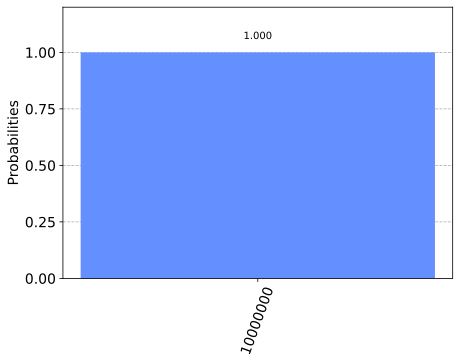

In [38]:
# 結果を表示する
# 7番目の量子ビットのみ反転し、1になる（Qiskitは文字列の右から左に0から番号をつける）
counts = execute(qc, Aer.get_backend("qasm_simulator")).result().get_counts()
plot_histogram(counts)

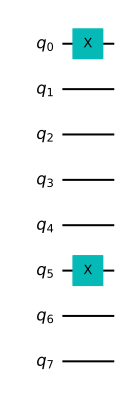

In [39]:
""" 数字の33をエンコードしてみる """
qc_encode2 = QuantumCircuit(n)

# 32 = 2^5 + 2^0
qc_encode2.x(0)
qc_encode2.x(5)

qc_encode2.draw()

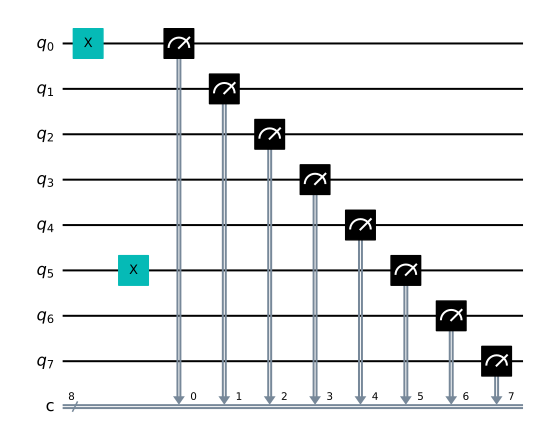

In [40]:
# 結果の抽出
qc2 = qc_encode2 + qc_output
qc2.draw(output="mpl", justify="none")

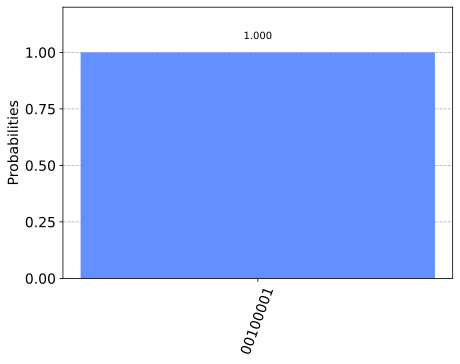

In [41]:
# 結果を表示する
counts = execute(qc2, Aer.get_backend("qasm_simulator")).result().get_counts()
plot_histogram(counts)

## 4.3 Qiskitで足し算

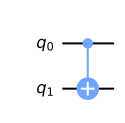

In [42]:
"""2つのビットの足し算
q[0]とq[1]：入力
c[0]とc[1]：結果

半加算器は、
q1 + q0  =c1c0
 0 +  0  =00
 0 +  1  =01
 1 +  0  =01
 1 +  1  =10
なので、
q0==q1のとき、c0=0
q0!=q1のとき、c0=1

q0==1 && q1==1のとき、c1=1
それいがいのとき、c1=0

CNOTゲートは、
* 制御ビットが0のとき、何もしない
* 制御ビットが1のとき、ターゲットビットを反転させる
"""
qc_cnot = QuantumCircuit(2)  # 2量子の回路を作成

# 古典におけるXORは、量子ではCNOTゲートで行う
qc_cnot.cx(0, 1)  # q[0]が制御、q[1]がターゲットのCNOTゲート
qc_cnot.draw()

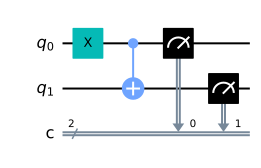

In [43]:
"""CNOTゲートのテスト"""
qc = QuantumCircuit(2, 2)  # A QuantumCircuit with 2 qubits and 2 classical bits（2入力 2出力）

# 入力：01
qc.x(0)

# CNOTゲート作成
qc.cx(0, 1)

# 測定ゲートを作る
qc.measure(0, 0)  # q[0] を測定し、結果を c[0]に書き込む
qc.measure(1, 1)  # q[1] を測定し、結果を c[1]に書き込む

# 回路を見る
qc.draw()

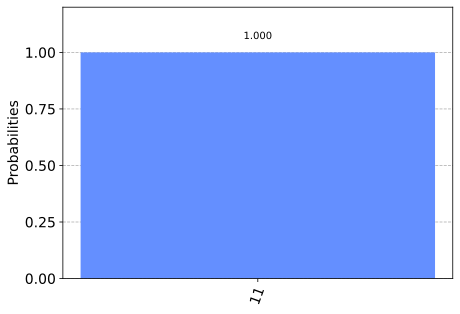

In [44]:
# 結果を表示する
counts = execute(qc, Aer.get_backend("qasm_simulator")).result().get_counts()
plot_histogram(counts)

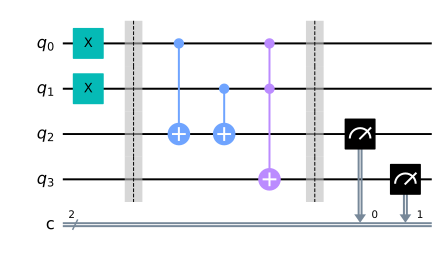

In [45]:
"""半加算器の作成"""
# 回路作成
qc_ha = QuantumCircuit(4, 2)  # 4 qubits, 2 classical bits（4入力、2出力）

# 1+1を計算したい
qc_ha.x(0)
qc_ha.x(1)
qc_ha.barrier()  # 点線を引く

# q[2]を決める回路（XOR回路）
qc_ha.cx(0, 2)
qc_ha.cx(1, 2)

# q[0]とq[1]が1のとき、q[3]を1にしたい。（1+1=10）
# そういうときは、両方の「制御量子ビットの状態が1の場合のみ、ターゲットにNOT操作をする」というToffoli（トフォリ）ゲートを使う。
# これが古典論理ゲート上のANDゲートに相当する。
qc_ha.ccx(0, 1, 3)  # q[0]とq[1]が1のとき、q[3]を反転させるToffoliゲート
qc_ha.barrier()

# extract outputs
qc_ha.measure(2, 0)  # extract XOR value
qc_ha.measure(3, 1)  # extract AND value

# 回路を見る
qc_ha.draw()

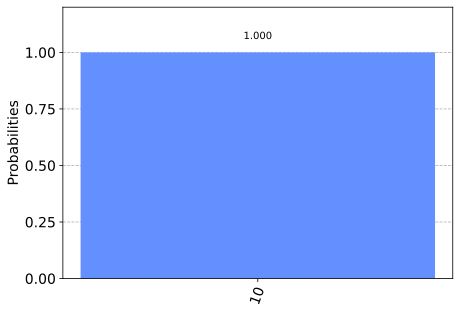

In [46]:
# 結果を表示
counts = execute(qc_ha,Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

In [47]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}